# Studying Scaling Behaviour of Real Space RG (Bialek Inspired)
In this notebook I will study the scaling behaviour of the real space renormalization group (RG) inspired technique that Bialek et al. 2020 proposed. In the paper they propose a greedy pairwise coarse-graining procedure. They test their algorithm on a dataset containing neuronal data of a mouse. 

Here we consider the same procedure but instead use data sampled from an Ising model and compare it with a Bernoulli (p=0.5) dataset that has 1) no correlation and 2) is maximally correlated.

Furthermore, we compare the pairwise coarse-graining procedure with a random pairwise coarse-graining procedure and study how the scaling is influenced by the change in procedure.

In [1]:
import numpy as np
import matplotlib.pyplot
import RG_class as rg
import pandas as pd
from plots_to_analyse_rg_scaling import *
import copy
import time
import warnings
warnings.filterwarnings('ignore')

## Loading the datasets
Lets start by loading in the datasets we want to study. We will load in the following 4 datasets

    1. 2d Ising model with L=16x16, T=4, J=1
    
    All below still need to be implemented... The bernoulli ones are probably best sampled from an Ising model
    2. 1d Ising model with L=256, T=4, J=1
    3. Bernoulli (p=0.5) L=256 uncorrelated spins
    4. Bernoulli (p=0.5) L=256 maximally correlated spins

### Filenames

In [2]:
file_data_2dising = "input/2d_Ising_model_samples.npy"
#f_data_1dising = ""

### Create a RGObject for each dataset we want to analyse

In [3]:
# Initialize a RGObject
RG_random = rg.RGObject()
RG_bialek = rg.RGObject()

# Load dataset
RG_random.load_dataset(file_data_2dising)
RG_bialek.X = copy.deepcopy(RG_random.X)

# Shape of the dataset
print(f"Size of dataset = {RG_random.X.shape}")

Dataset contains binary values [-1, 1].
Size of dataset = (256, 16384)


## To get a feel of the dataset lets have a look at the pairwise correlations

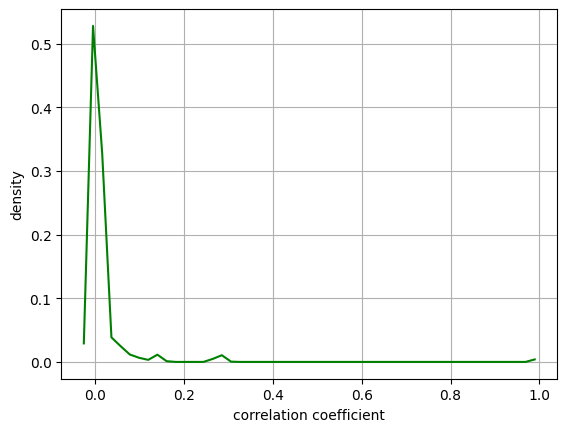

In [4]:
RG_random.plot_correlation_structure_in_dataset()

## Now lets perform two different RG transformations (RGTs) on the dataset
    
1. **method = "random";** perform a random pairwise coarse-graining procedure. At each RG step we reduce the number of spins from N to N/2 by randomly pairing them.

2. **method = "pairwise_clustering_bialek";** perform a pairwise coarse-graining procedure based on the correlation matrix. At each RG step we reduce the number of spins from N to N/2 by 1) finding the highest correlated spins, 2) creating a new spin which contains the normalized summed activity. 3) find next pair and do till every spin is paired.
    

In [5]:
# Lets quickly check the names of the possible RGTs
RG_bialek.list_methods()

Possible ways to perform the Renormalization group are:
 - 'random': this does a random pairwise clustering at eacht step.
 - 'pairwise_clustering_bialek': this does a pairwise clustering of the highest correlated variables.
 - 'RBM': this trains a set of Restricted Boltzmann Machines at each RG transformation.


In [6]:
# Number of RGTs to perform
rg_iterations = 5

# Perform random RGTs
t = time.time()
RG_random.perform_real_space_coarse_graining("random", rg_iterations)
print(f"Random RGTs toke {round(time.time() - t, 3)} seconds.")

# Perform Bialek RGTs
t = time.time()
RG_bialek.perform_real_space_coarse_graining("pairwise_clustering_bialek", rg_iterations)
print(f"Bialek RGTs toke {round(time.time() - t, 3)} seconds.")

Random RGTs toke 0.116 seconds.
Bialek RGTs toke 0.264 seconds.


## RGTs completed! Extract the data and lets study it.

1. First we compute the **probability distributions of the normalized activity in the clusters**. From this we can find the Free Energy scaling and get an indication about the simplification of the distribution. If the system is moving towards a fixed distribution we can say that we are in a RG fixed point.


2. Furthermore, we can look at the **eigenvalue spectra withing the clusters**. We should expect to see an exponentially decaying spectrum because we know that coarse-graining only makes sense if the high frequency modes (which in a rank/K plot are the right most values) should become less and less relevant for the variance in the clusters. 

    Something else to look at is the **variance of the eigenspectra**. This should indicate how consistent the coarse-graining procedure is across the different clusters that are formed. High variacne indicates the procedure is not consistently able to average over the same frequency modes. Low variance indicates the opposite.

In [7]:
# Extract data 
Xs_random, clusters_random, _ = RG_random.extract_data()
Xs_bialek, clusters_bialek, _ = RG_bialek.extract_data()

# Compute distributions
p_averages_random, p_stds_random, unique_activity_values_random = RG_random.compute_probability_distributions()
p_averages_bialek, p_stds_bialek, unique_activity_values_bialek = RG_bialek.compute_probability_distributions()

Total running time = 0.908 seconds.
Total running time = 0.873 seconds.


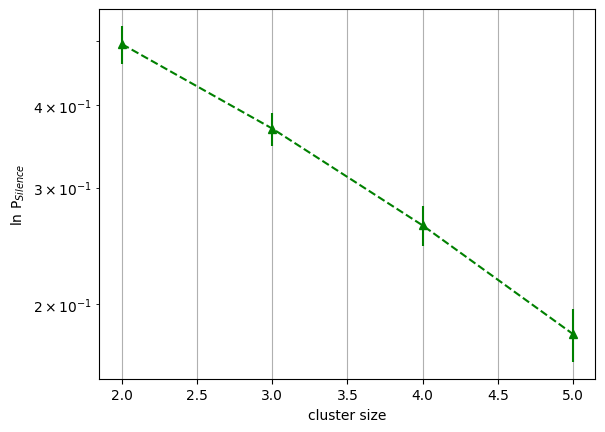

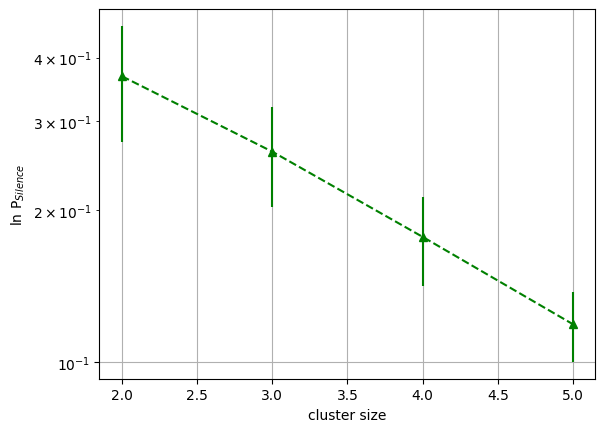

In [8]:
# Plot free energy 
plot_free_energy_scaling(p_averages_random, p_stds_random, unique_activity_values_random)
plot_free_energy_scaling(p_averages_bialek, p_stds_bialek, unique_activity_values_bialek)

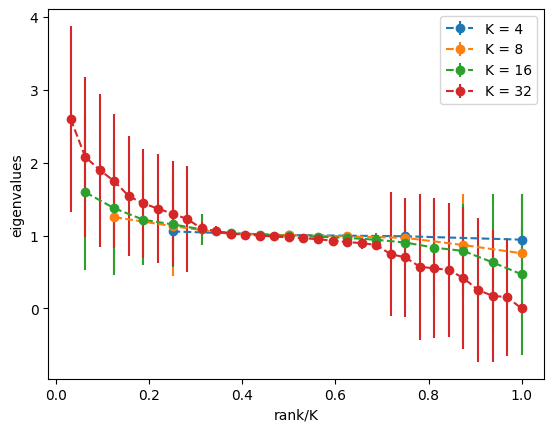

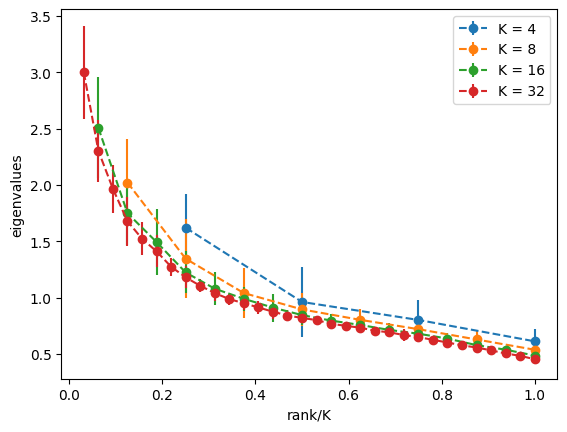

In [9]:
# Plot eigenvalue spectra
plot_eigenvalue_spectra_within_clusters(Xs_random, clusters_random)
plot_eigenvalue_spectra_within_clusters(Xs_bialek, clusters_bialek)

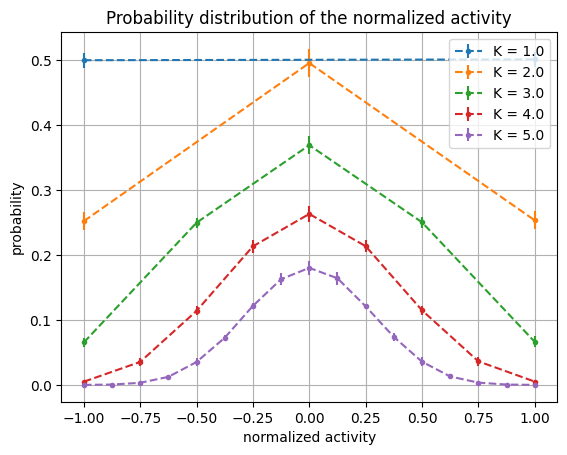

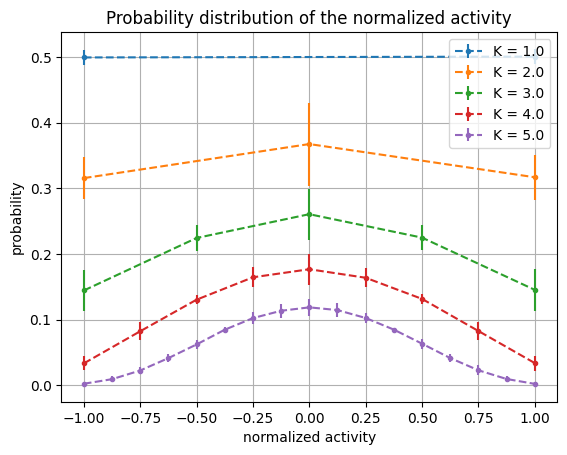

In [10]:
# Plot distribution of activity
plot_normalized_activity(p_averages_random, p_stds_random, unique_activity_values_random)
plot_normalized_activity(p_averages_bialek, p_stds_bialek, unique_activity_values_bialek)

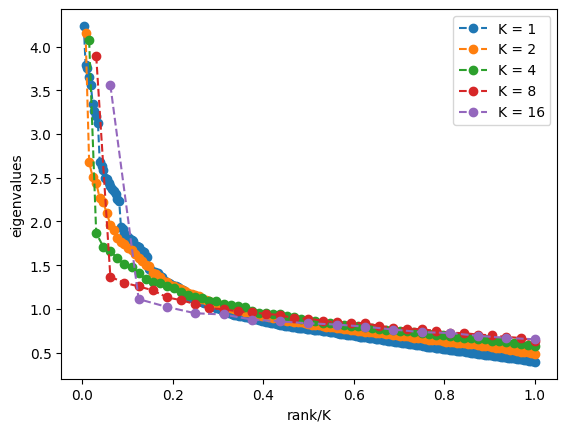

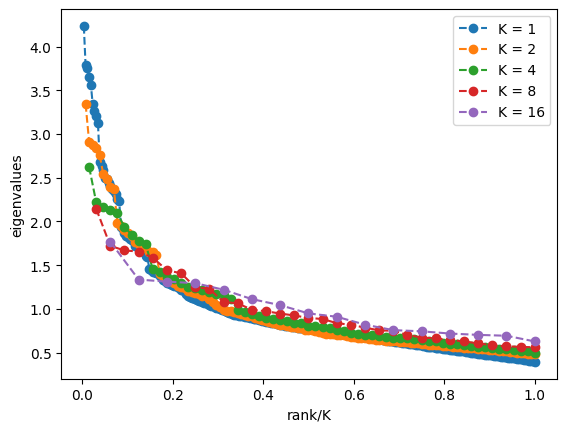

In [11]:
# Plot the eigenvalue spectrum of the coarse-grained variables at different points in the RGTs
plot_eigenvalue_scaling(Xs_random)
plot_eigenvalue_scaling(Xs_bialek)

Random
###############################


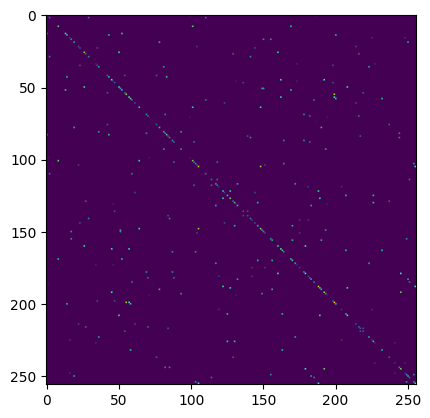

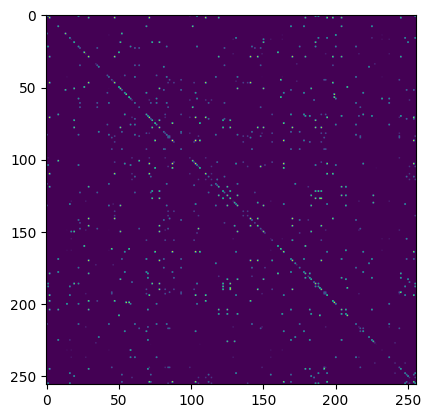

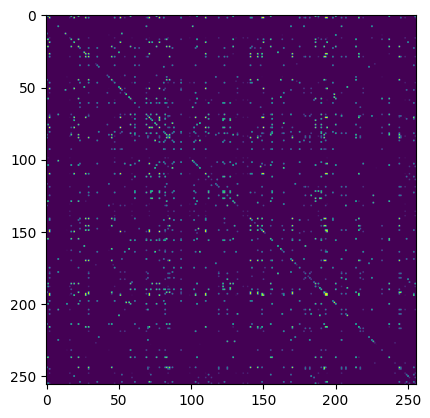

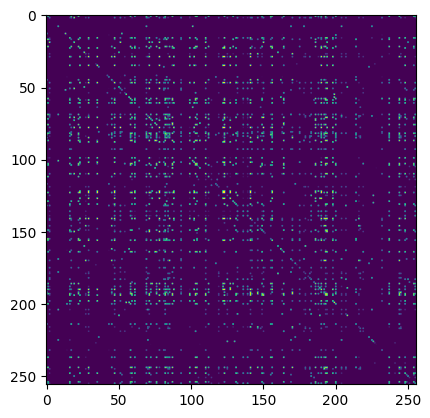

Bialek
###############################


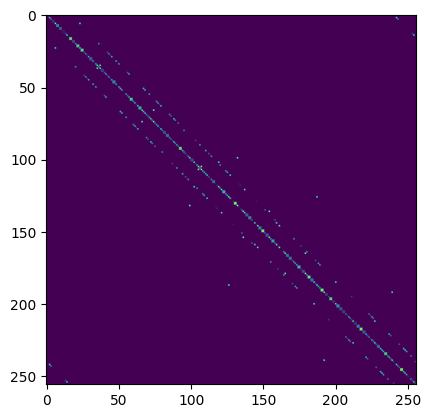

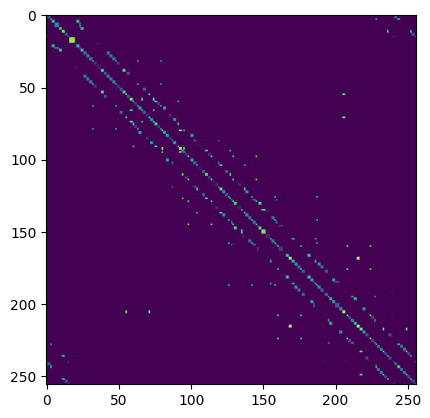

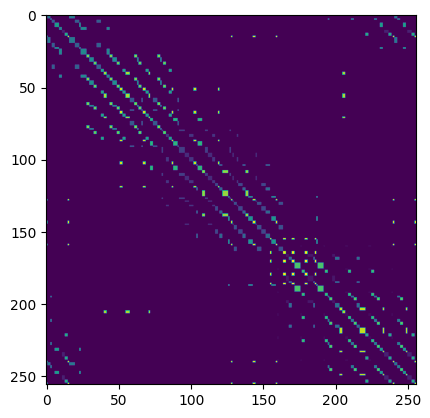

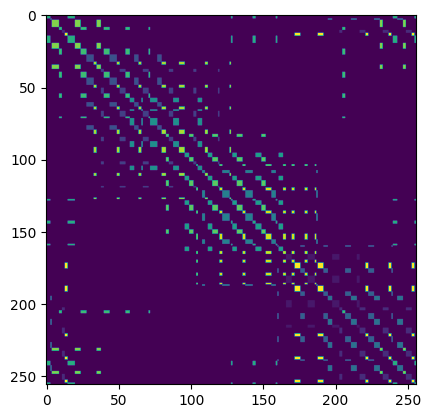

In [14]:
print("Random\n###############################")
show_clusters_by_imshow(clusters_random)
print("Bialek\n###############################")
show_clusters_by_imshow(clusters_bialek)

In [ ]:
n = 5
plot_n_largest_eigenvectors(Xs, n)

In [ ]:
X = np.random.randint(0, 2, (256, 2**14))
X.shape

In [ ]:
U, C = np.unique(X.T, axis=1, return_counts=True)
print(U.shape, C.shape)
U, C

In [ ]:
for i in range(5):
    n = (2 ** (i) + 1)
    xk = np.linspace(-1, 1, n)
    pk = np.zeros(len(xk))
    d = dict(zip(xk, pk))

    if i == 4:
        counts = xk[2:6] * 10
        print(d)
        for j, x in enumerate(xk[2:6]):
            d[x] = counts[j]
        print()
        print(d)

In [ ]:
import scipy.stats as st

dir(st.rv_histogram)

### 